## JWST F770W NGC628 ERO

Data is setup in a subdirectory that is given in the filter variable below (i.e., "F560W"). Inside this directory, there should be 4 subdirectories called stage0, stage1, stage2, and stage3. The uncal (raw) fits files should be in the stage0 directory.

Author: Karl Gordon

Last modified: 28 Jul 2022

Based on JWebbinar notebooks by Bryan Hilbert, MIRI simulated notebooks by Mattia Libralato, input from various MIRI team members, and input from the jwst pipeline developers.

Uses custom code given in helpers subdirectory.

Extensively tested on MIRI ERO mosaics.

### Variables controling processing and display

In [1]:
filter = "F770W"
fwhm = 2.2
basename = "jw021070"

# rotation = 0.0
crval = None
rotation = None

# shifts determine from previous runs with treakreg or with other filters
#   analysis using Analyze_teakreg_shifts.ipynb
#   run this notebook after running shortest wavelength dataset with tweakreg=True and align_to_gaia=True
#     and setting all the tile?_shifts to [0.0, 0.0]
#   use the resulting shifts here and set tweakreg=False and align_to_gaia=False
tile1_shifts = [0.0, 0.0]
tile2_shifts = [0.0, 0.0]
tile3_shifts = [0.0, 0.0]
tile4_shifts = [0.0, 0.0]
tile5_shifts = [0.0, 0.0]
#tweakreg = True
#align_to_gaia = True
#tile1_shifts = [-0.05647150365601337, -0.2759964433337788]
#tile2_shifts = [0.25227164704614663, -0.31523502700888206]
#tile3_shifts = [-0.2545612377015838, -0.3166996893456614]
#tile4_shifts = [-0.257545863147537, -0.31632086761441347]
#tile5_shifts = [-0.2575264791579155, -0.3163360127396757]
tweakreg = False
align_to_gaia = False

# only needed if multiple datasets combined that are taken separately (e.g., weeks apart)
matchbkg = False

# display range for uncalibrated images
drange_raw = [15., 350.]
# display range for calibrated images
drange_cal = [4., 200.]
dmap = "afmhot"  # same as ds9 bb

# specify the linearity file to use if default not desired
# linfile = ""
linfile = None

# specify the flat file to use if default not desired
flatfile = None

run_detector1 = False
run_image2 = False
run_image3 = True

In [2]:
import os
import glob
import copy

from astropy.io import ascii
from astropy.visualization import simple_norm

In [3]:
import astropy
print(astropy.__version__)

5.0.4


In [4]:
os.environ["CRDS_PATH"] = "/home/kgordon/crds_cache"
os.environ["CRDS_SERVER_URL"] = "https://jwst-crds.stsci.edu"

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import ImageGrid

# Use this version for non-interactive plots (easier scrolling of the notebook)
%matplotlib inline

# Use this version (outside of Jupyter Lab) if you want interactive plots
#%matplotlib notebook

# These gymnastics are needed to make the sizes of the figures
# be the same in both the inline and notebook versions
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}

mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

In [6]:
# List of possible data quality flags
from jwst.datamodels import dqflags
from jwst import datamodels

from jwst.associations import asn_from_list
from jwst.associations.lib.rules_level2_base import DMSLevel2bBase
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base

# custom helper routines
from helpers.jwst_helpers import show_image, overlay_catalog
from helpers.miri_helpers import miri_detector1, miri_image2, miri_image3
from helpers.miri_clean import fix_rateints_to_rate, shift_cal_wcs

In [7]:
import jwst
print(jwst.__version__)

1.6.3.dev1+g3e8a10cb.d20220719


In [8]:
import stcal
print(stcal.__version__)

1.0.1.dev1+g51f5dfc


In [9]:
# create stage directories if they do not exist
for k in range(4):
    cpath = f"./{filter}/stage{k}"
    if not os.path.exists(cpath):
        os.makedirs(cpath)

## CALWEBB_DETECTOR1

In [10]:
miri_uncal_files = glob.glob(f"./{filter}/stage0/*uncal.fits")
output_dir = f'./{filter}/stage1'
print(miri_uncal_files)

['./F770W/stage0/jw02107039001_02101_00001_mirimage_uncal.fits', './F770W/stage0/jw02107039001_02101_00002_mirimage_uncal.fits', './F770W/stage0/jw02107039001_02101_00003_mirimage_uncal.fits', './F770W/stage0/jw02107039001_02101_00004_mirimage_uncal.fits', './F770W/stage0/jw02107039002_02101_00001_mirimage_uncal.fits', './F770W/stage0/jw02107039002_02101_00002_mirimage_uncal.fits', './F770W/stage0/jw02107039002_02101_00003_mirimage_uncal.fits', './F770W/stage0/jw02107039002_02101_00004_mirimage_uncal.fits', './F770W/stage0/jw02107039003_02101_00001_mirimage_uncal.fits', './F770W/stage0/jw02107039003_02101_00002_mirimage_uncal.fits', './F770W/stage0/jw02107039003_02101_00003_mirimage_uncal.fits', './F770W/stage0/jw02107039003_02101_00004_mirimage_uncal.fits', './F770W/stage0/jw02107040001_02201_00001_mirimage_uncal.fits', './F770W/stage0/jw02107040001_02201_00002_mirimage_uncal.fits', './F770W/stage0/jw02107040001_02201_00003_mirimage_uncal.fits', './F770W/stage0/jw02107040001_02201_000

In [11]:
if run_detector1:
    miri_detector1(miri_uncal_files, output_dir, linfile=linfile)

In [12]:
# fix the making of the rate images from the rateints images
#   needed for multiple integrations in regions near saturation
miri_rate_files = glob.glob(f"./{filter}/stage1/*ge_rate.fits")
for cfile in miri_rate_files:
    fix_rateints_to_rate(cfile)

In [13]:
# look at one of the images
miri_rate_files = glob.glob(f"./{filter}/stage1/*ge_fixed_rate.fits")
miri_rate = datamodels.open(miri_rate_files[0])
drange = drange_raw

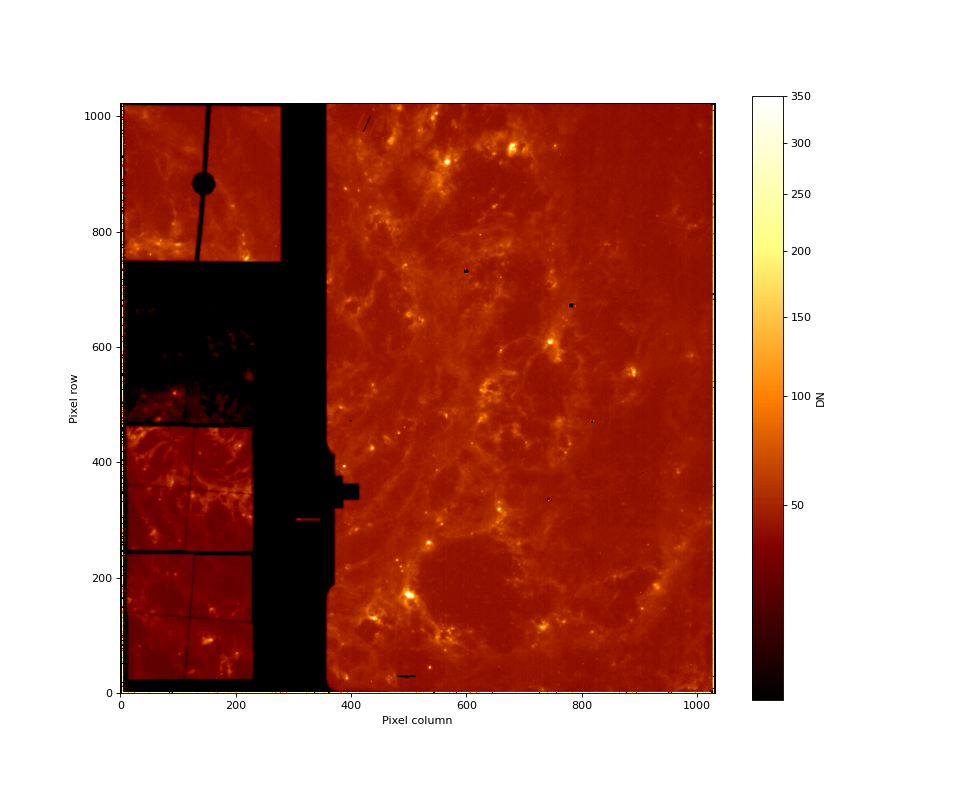

In [14]:
show_image(miri_rate.data, vmin=drange[0], vmax=drange[1], dmap=dmap)

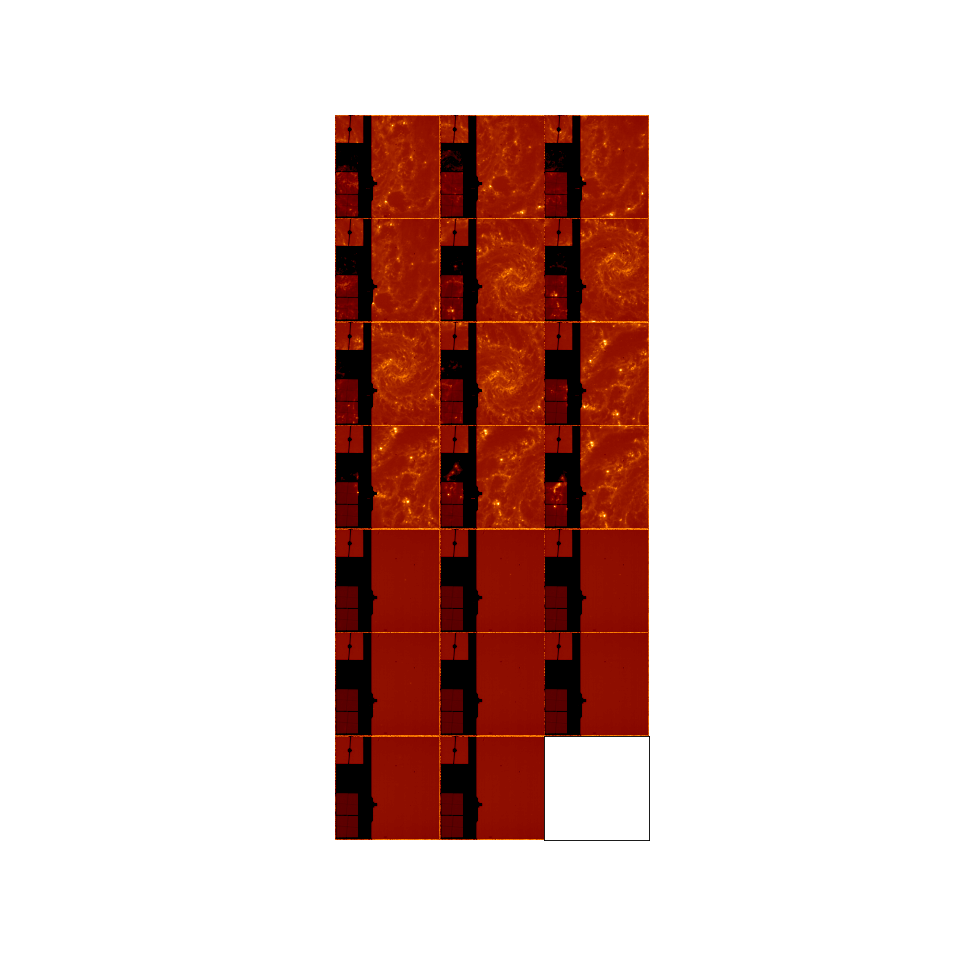

In [15]:
# display the images
fig = plt.figure(1, figsize=(12, 12))
ncols = len(miri_rate_files) // 3
grid = ImageGrid(fig, 111, nrows_ncols=(ncols+1, 3), axes_pad=0)

for i, cfile in enumerate(miri_rate_files):
    with datamodels.open(cfile) as miri_rate:
        cimage = miri_rate.data
        norm_data = simple_norm(cimage, "sqrt", min_cut=drange[0], max_cut=drange[1])
        grid[i].imshow(cimage, norm=norm_data, origin="lower", cmap=plt.get_cmap(dmap))
        grid[i].axis('off')
        grid[i].set_xticks([])
        grid[i].set_yticks([])

## CALWEBB_IMAGE2

In [16]:
miri_rate_files = glob.glob(f"./{filter}/stage1/*ge_fixed_rate.fits")
output_dir = f'./{filter}/stage2'
print(miri_rate_files)

['./F770W/stage1/jw02107039001_02101_00001_mirimage_fixed_rate.fits', './F770W/stage1/jw02107039001_02101_00002_mirimage_fixed_rate.fits', './F770W/stage1/jw02107039001_02101_00003_mirimage_fixed_rate.fits', './F770W/stage1/jw02107039001_02101_00004_mirimage_fixed_rate.fits', './F770W/stage1/jw02107039002_02101_00001_mirimage_fixed_rate.fits', './F770W/stage1/jw02107039002_02101_00002_mirimage_fixed_rate.fits', './F770W/stage1/jw02107039002_02101_00003_mirimage_fixed_rate.fits', './F770W/stage1/jw02107039002_02101_00004_mirimage_fixed_rate.fits', './F770W/stage1/jw02107039003_02101_00001_mirimage_fixed_rate.fits', './F770W/stage1/jw02107039003_02101_00002_mirimage_fixed_rate.fits', './F770W/stage1/jw02107039003_02101_00003_mirimage_fixed_rate.fits', './F770W/stage1/jw02107039003_02101_00004_mirimage_fixed_rate.fits', './F770W/stage1/jw02107040001_02201_00001_mirimage_fixed_rate.fits', './F770W/stage1/jw02107040001_02201_00002_mirimage_fixed_rate.fits', './F770W/stage1/jw02107040001_022

In [17]:
if run_image2:
    miri_image2(miri_rate_files, output_dir, flatfile=flatfile)

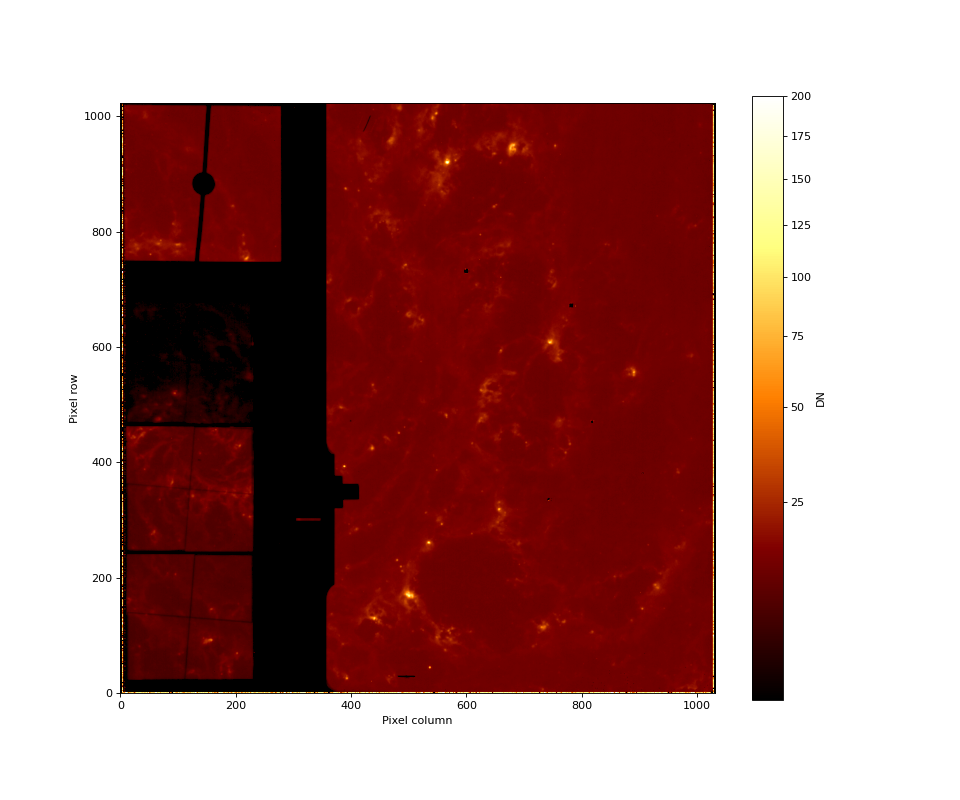

In [18]:
drange = drange_cal
# look at one of the images
miri_cal_files = glob.glob(f"./{filter}/stage2/*ge_fixed_cal.fits")
miri_cal = datamodels.open(miri_cal_files[0])
show_image(miri_cal.data, vmin=drange[0], vmax=drange[1], dmap=dmap)

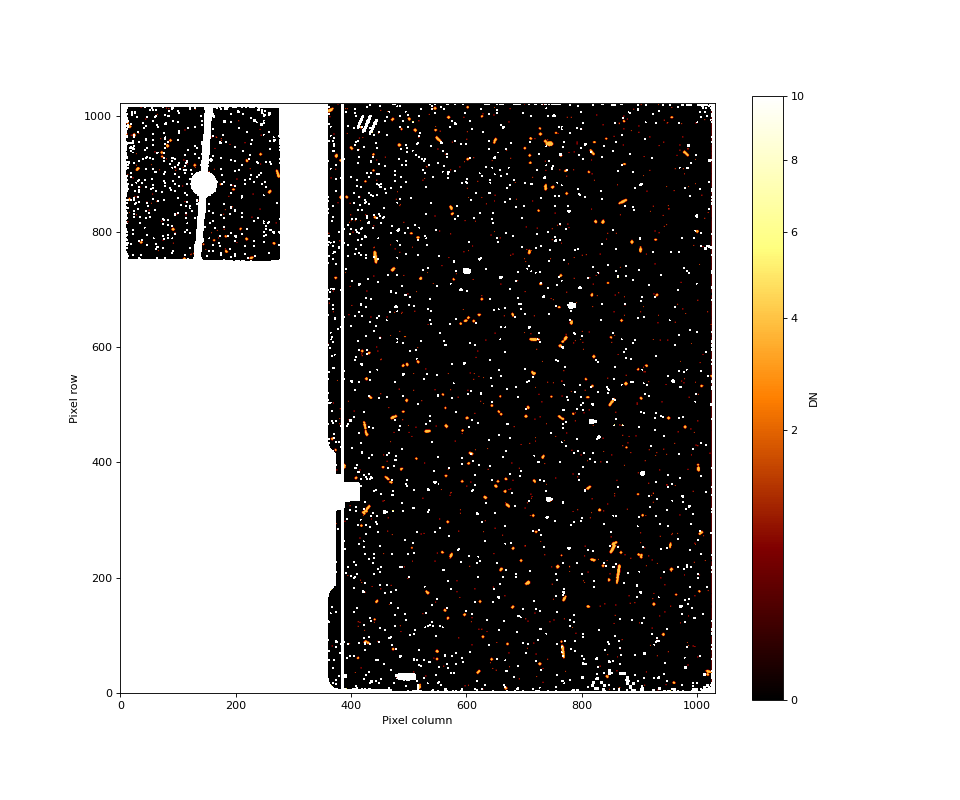

In [19]:
show_image(miri_cal.dq, 0, 10, dmap=dmap)

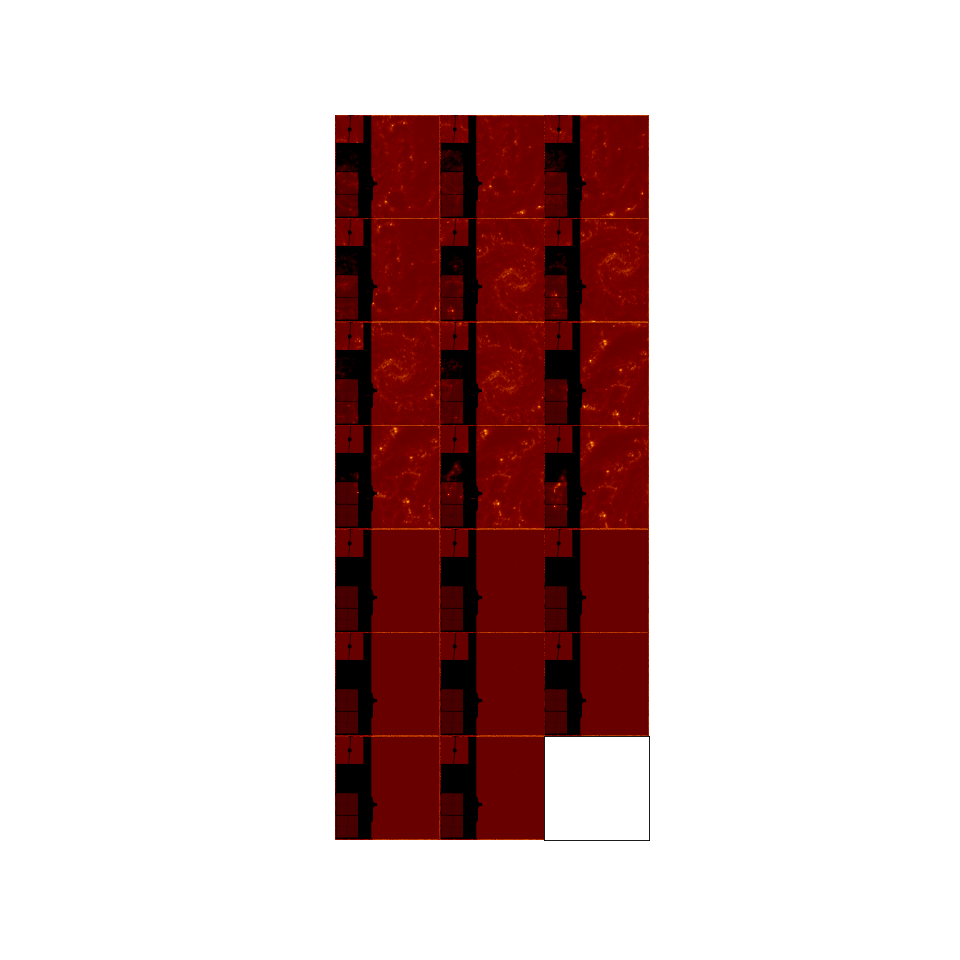

In [20]:
# display the images
fig = plt.figure(1, figsize=(12, 12))
ncols = len(miri_cal_files) // 3
grid = ImageGrid(fig, 111, nrows_ncols=(ncols+1, 3), axes_pad=0)

for i, cfile in enumerate(miri_cal_files):
    with datamodels.open(cfile) as miri_cal:
        cimage = miri_cal.data
        norm_data = simple_norm(cimage, "sqrt", min_cut=drange[0], max_cut=drange[1])
        grid[i].imshow(cimage, norm=norm_data, origin="lower", cmap=plt.get_cmap(dmap))
        grid[i].axis('off')
        grid[i].set_xticks([])
        grid[i].set_yticks([])

## CALWEBB_IMAGE3

In [21]:
# update the WCS for mosaic tile 1
miri_cal_files = glob.glob(f"./{filter}/stage2/{basename}39001*ge_fixed_cal.fits")
for cfile in miri_cal_files:
    shift_cal_wcs(cfile, tile1_shifts)

# update the WCS for mosaic tile 2
miri_cal_files = glob.glob(f"./{filter}/stage2/{basename}39002*ge_fixed_cal.fits")
for cfile in miri_cal_files:
    shift_cal_wcs(cfile, tile2_shifts)
    
# update the WCS for mosaic tile 3
miri_cal_files = glob.glob(f"./{filter}/stage2/{basename}39003*ge_fixed_cal.fits")
for cfile in miri_cal_files:
    shift_cal_wcs(cfile, tile3_shifts)
    
# update the WCS for mosaic tile 4
miri_cal_files = glob.glob(f"./{filter}/stage2/{basename}40001*ge_fixed_cal.fits")
for cfile in miri_cal_files:
    shift_cal_wcs(cfile, tile4_shifts)
    
# update the WCS for mosaic tile 5
miri_cal_files = glob.glob(f"./{filter}/stage2/{basename}40002*ge_fixed_cal.fits")
for cfile in miri_cal_files:
    shift_cal_wcs(cfile, tile5_shifts)

In [22]:
miri_cal_files = glob.glob(f"./{filter}/stage2/j*ge_fixed_wcs_cal.fits")
output_dir = f"./{filter}/stage3/"
print(miri_cal_files)

if rotation is not None:
    miri_asn_name = f'miri_{filter}_stage3_fixedrot_asn'
else: 
    miri_asn_name = f'miri_{filter}_stage3_asn'
miri_asn = asn_from_list.asn_from_list(miri_cal_files, rule=DMS_Level3_Base, product_name=miri_asn_name)

miri_asn_file = f'{miri_asn_name}.json'
with open(miri_asn_file, 'w') as outfile:
    name, serialized = miri_asn.dump(format='json')
    outfile.write(serialized)
    
print(miri_asn_file)

['./F770W/stage2/jw02107039001_02101_00001_mirimage_fixed_wcs_cal.fits', './F770W/stage2/jw02107039001_02101_00002_mirimage_fixed_wcs_cal.fits', './F770W/stage2/jw02107039001_02101_00003_mirimage_fixed_wcs_cal.fits', './F770W/stage2/jw02107039001_02101_00004_mirimage_fixed_wcs_cal.fits', './F770W/stage2/jw02107039002_02101_00001_mirimage_fixed_wcs_cal.fits', './F770W/stage2/jw02107039002_02101_00002_mirimage_fixed_wcs_cal.fits', './F770W/stage2/jw02107039002_02101_00003_mirimage_fixed_wcs_cal.fits', './F770W/stage2/jw02107039002_02101_00004_mirimage_fixed_wcs_cal.fits', './F770W/stage2/jw02107039003_02101_00001_mirimage_fixed_wcs_cal.fits', './F770W/stage2/jw02107039003_02101_00002_mirimage_fixed_wcs_cal.fits', './F770W/stage2/jw02107039003_02101_00003_mirimage_fixed_wcs_cal.fits', './F770W/stage2/jw02107039003_02101_00004_mirimage_fixed_wcs_cal.fits', './F770W/stage2/jw02107040001_02201_00001_mirimage_fixed_wcs_cal.fits', './F770W/stage2/jw02107040001_02201_00002_mirimage_fixed_wcs_ca

In [23]:
if run_image3:
    miri_image3(miri_asn_file, output_dir, fwhm=fwhm, matchbkg=matchbkg, 
                crval=crval, rotation=rotation, 
                tweakreg=tweakreg, align_to_gaia=align_to_gaia)

2022-07-28 10:29:10,761 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.
2022-07-28 10:29:10,763 - stpipe - CRITICAL - config: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_mtwcs', 'search_output_file': True, 'input_dir': None, 'class': ''}


2022-07-28 10:29:10,764 - stpipe.Image3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.
2022-07-28 10:29:10,767 - stpipe - CRITICAL - config: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': None, 'save_catalogs': False, 'catalog_format': 'ecsv', 'kernel_fwhm': 2.5, 'snr_threshold': 10.0, 'brightest': 200, 'peakmax': None, 'enforce_user_order': False, 'expand_re

2022-07-28 10:29:12,164 - stpipe.Image3Pipeline - INFO - Prefetch for DRIZPARS reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_drizpars_0001.fits'.
2022-07-28 10:29:12,165 - stpipe.Image3Pipeline - INFO - Starting calwebb_image3 ...
2022-07-28 10:29:19,676 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg running with args (<ModelContainer>,).
2022-07-28 10:29:19,681 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_catalogs': False, 'catalog_format': 'ecsv', 'kernel_fwhm': 2.2, 'snr_threshold': 5, 'brightest': 200, 'peakmax': None, 'enforce_user_order': False, 'expand_refcat': False, 'minobj': 5, 'searchrad': 5.0, 'use2dhist': True, 'separation': 1.0, 'tolerance': 0.7, 'xoffset': 

2022-07-28 10:31:15,789 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (2092, 5648)
2022-07-28 10:31:15,854 - stpipe.Image3Pipeline.outlier_detection - INFO - Flagging outliers
2022-07-28 10:31:16,038 - stpipe.Image3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 1244 (0.12%)
2022-07-28 10:31:16,207 - stpipe.Image3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 1346 (0.13%)
2022-07-28 10:31:16,381 - stpipe.Image3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 764 (0.07%)
2022-07-28 10:31:16,550 - stpipe.Image3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 466 (0.04%)
2022-07-28 10:31:16,724 - stpipe.Image3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 490 (0.05%)
2022-07-28 10:31:16,890 - stpipe.Image3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 420 (0.04%)
2022-07-28 10:31:17,057 - stpipe.Image3Pipeline.outlier_detection - INFO - Ne

2022-07-28 10:31:46,590 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (2110, 5696)
2022-07-28 10:31:48,214 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (2110, 5696)
2022-07-28 10:31:50,022 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (2110, 5696)
2022-07-28 10:31:52,010 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (2110, 5696)
2022-07-28 10:31:54,088 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (2110, 5696)
2022-07-28 10:31:56,569 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (2110, 5696)
2022-07-28 10:31:59,015 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (2110, 5696)
2022-07-28 10:32:01,348 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (2110, 5696)
2022-07-28 10:32:03,637 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (2110, 5696)
2022-07-28 10:32:05,951 - stpipe.Image3Pipelin

2022-07-28 10:34:04,921 - stpipe.Image3Pipeline.resample - INFO - Saved model in ./F770W/stage3/miri_F770W_stage3_asn_i2d.fits
2022-07-28 10:34:04,922 - stpipe.Image3Pipeline.resample - INFO - Step resample done
2022-07-28 10:34:05,324 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog running with args (<ImageModel(2110, 5696) from miri_F770W_stage3_asn_i2d.fits>,).
2022-07-28 10:34:05,329 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'cat', 'search_output_file': True, 'input_dir': '', 'bkg_boxsize': 1000, 'kernel_fwhm': 2.0, 'snr_threshold': 5, 'npixels': 25, 'deblend': False, 'aperture_ee1': 30, 'aperture_ee2': 50, 'aperture_ee3': 70, 'ci1_star_threshold': 2.0, 'ci2_star_threshold': 1.8}
2022-07-28 10:34:05,386 - stpipe.Image3Pipeli

In [24]:
# Look at the resulting mosaic image
miri_mosaic_file = output_dir + miri_asn_name + '_i2d.fits'
miri_catalog_file = output_dir + miri_asn_name + '_cat.ecsv'

In [25]:
# Open the mosaic image
miri_mosaic = datamodels.open(miri_mosaic_file)

In [26]:
# Read in the source catalog
miri_source_cat = ascii.read(miri_catalog_file)

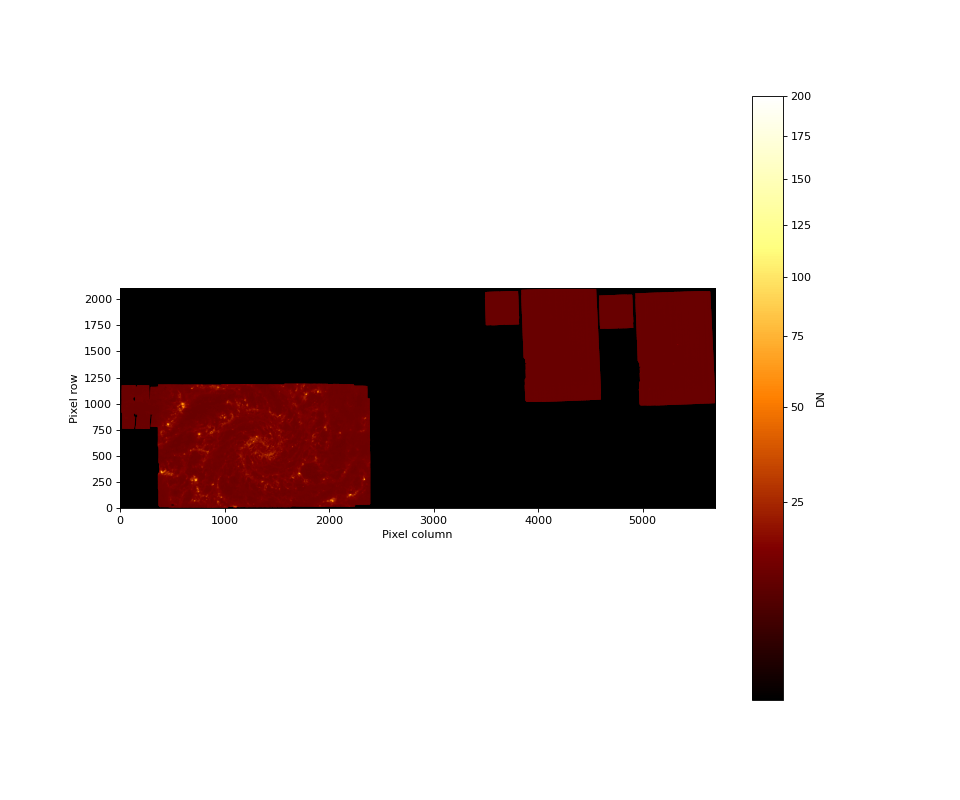

In [27]:
# Look at the mosaic
show_image(miri_mosaic.data, vmin=drange[0], vmax=drange[1], dmap=dmap)

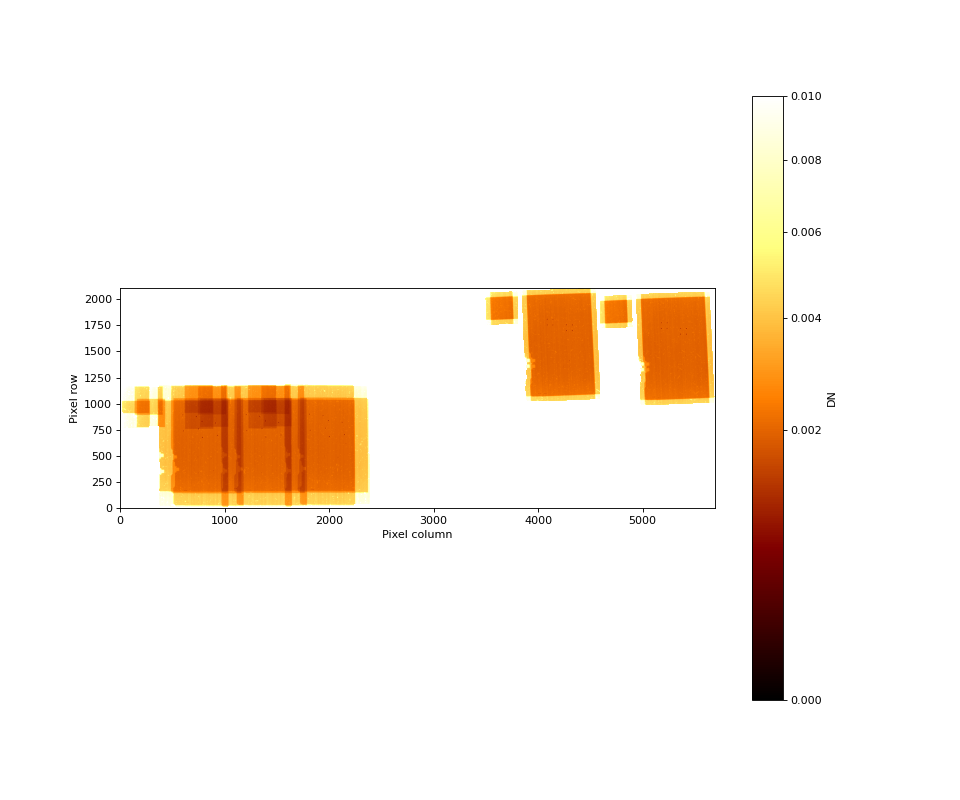

In [28]:
# Look at the mosaic data read noise uncertainties (i.e., coverage map)
show_image(miri_mosaic.var_rnoise, vmin=0.0, vmax=0.01, dmap=dmap)

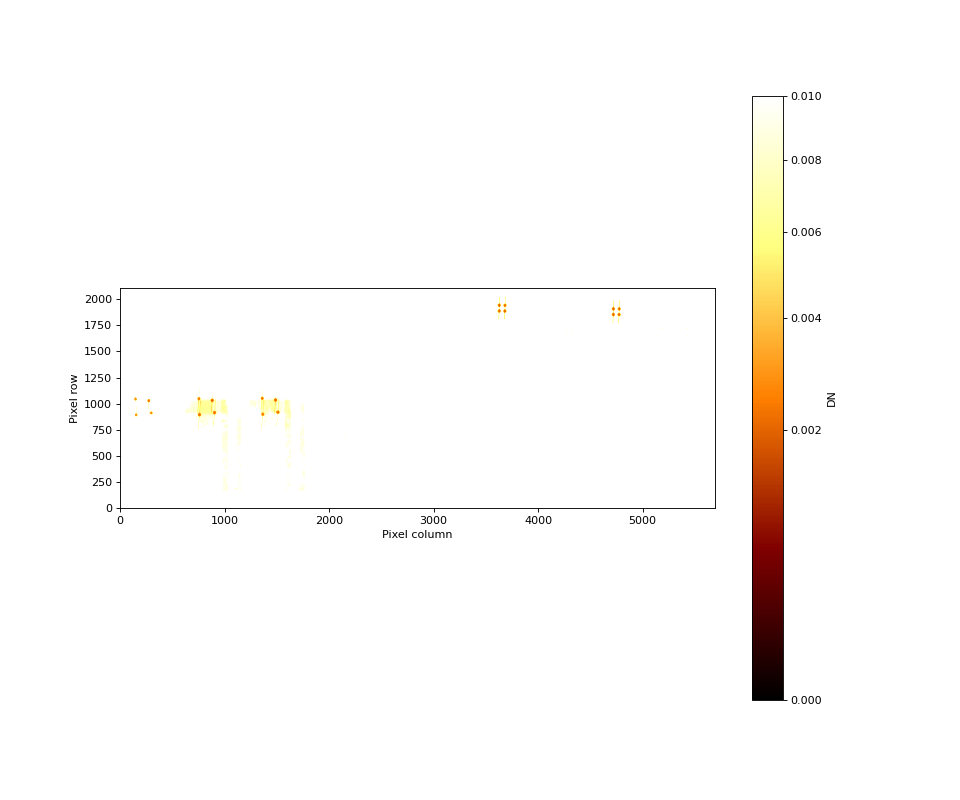

In [29]:
# Look at the mosaic data poisson uncertainties
show_image(miri_mosaic.var_poisson, vmin=0, vmax=0.01, dmap=dmap)

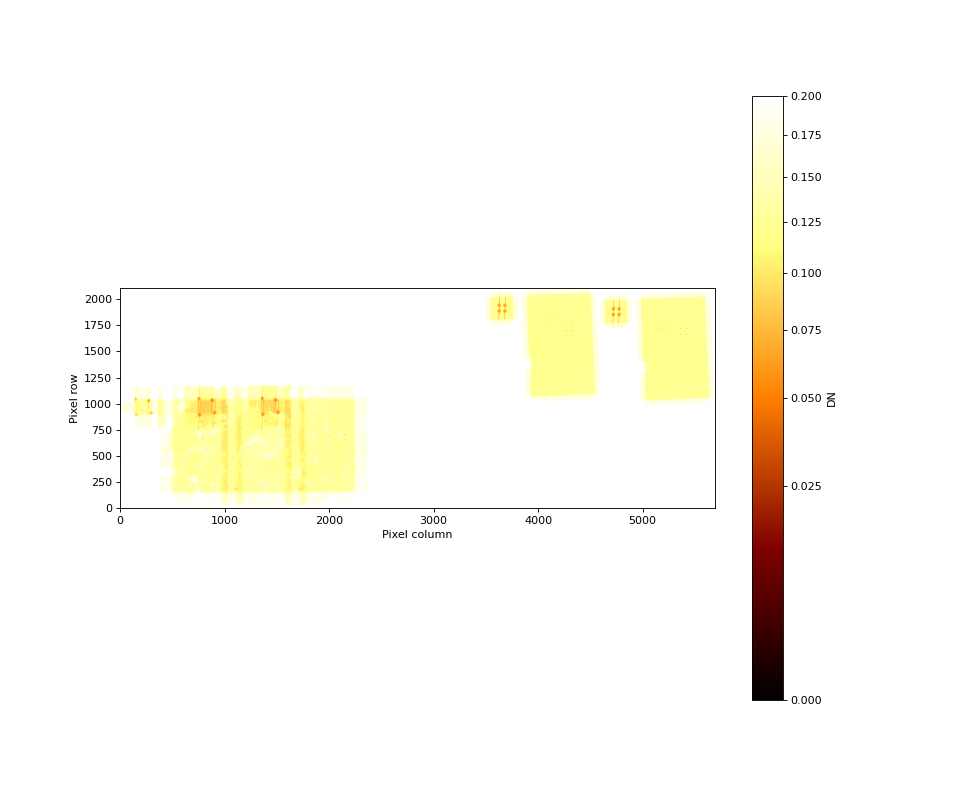

In [30]:
# Look at the mosaic total data uncertainties
show_image(miri_mosaic.err, vmin=0, vmax=0.2, dmap=dmap)

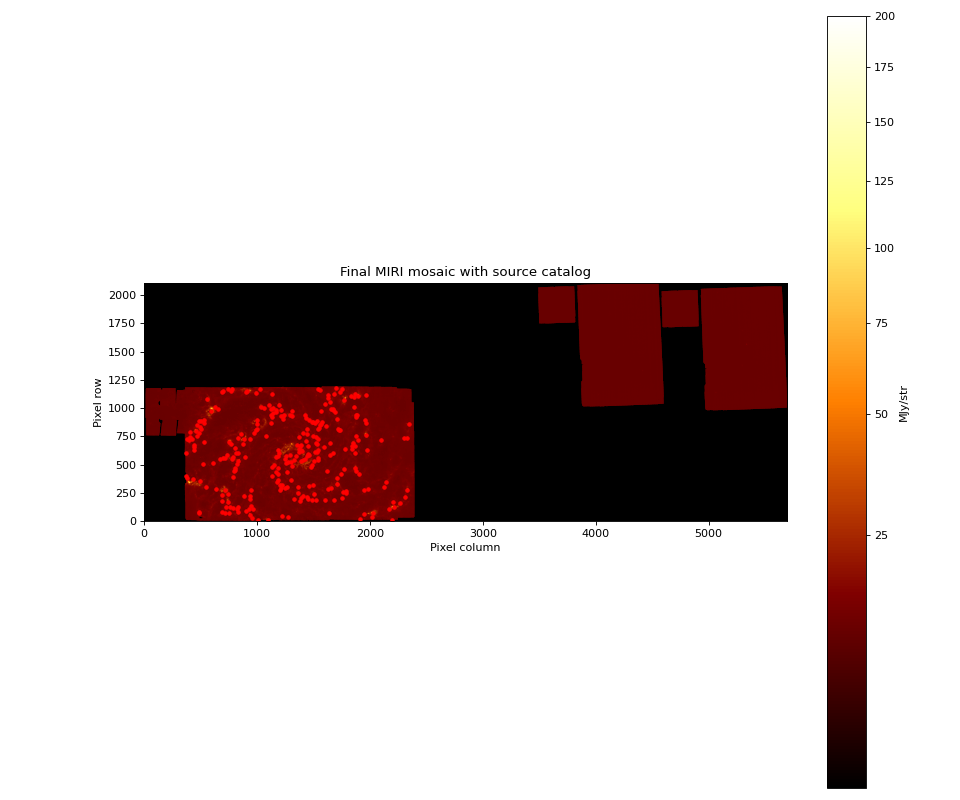

In [31]:
# Show the catalog sources on the mosaic
overlay_catalog(miri_mosaic.data, miri_source_cat, flux_limit=5e-7, vmin=drange[0], vmax=drange[1],
                title='Final MIRI mosaic with source catalog', dmap=dmap)